# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет **систему компьютерного зрения** для обработки фотографий покупателей. 

Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Нашей **целью** является построить модель, которая по фотографии определит приблизительный возраст человека. 

В нашем распоряжении **[набор фотографий людей с указанием возраста](https://chalearnlap.cvc.uab.cat/dataset/26/description/)**.


**Этапы выполнения проекта**:
1.	Провести исследовательский анализ набора фотографий.
2.	Подготовить данные к обучению.
3.	Обучить нейронную сеть и рассчитать её качество.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение модели</a></span></li></ul></div>

## Исследовательский анализ данных

На начальном этапе стоит провести исследовательский анализ данных:
1. Посмотрим на размер выборки.
2. Построим график распределения возраста в выборке.
3. Напечатаем на экране 10–15 фотографий и посмотрим, как устроен датасет.

Подгрузим необходимые библиотеки:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, ModelCheckpoint

Зафиксируем значение `random_seed` для воспроизводимости результатов, а так же прочие константы.


In [2]:
SEED = 12345
SIZE = 224 # размер изображения

Подключим Гугл-диск

In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


Посмотрим, как называется папка гугл-диска

In [4]:
!ls /content/gdrive/

MyDrive


In [5]:
!ls -l /content/gdrive/MyDrive/DS/YP/appa-real-release.zip

-rw------- 1 root root 885442010 Mar 24 21:46 /content/gdrive/MyDrive/DS/YP/appa-real-release.zip


In [6]:
!unzip -q /content/gdrive/MyDrive/DS/YP/appa-real-release.zip

replace appa-real-release/gt_avg_valid.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


Посмотрим, что за файлы распаковались


In [7]:
!ls

appa-real-release  drive  gdrive  sample_data


Прочитаем файл с метками возраста.

In [8]:
try:
    labels_train = pd.read_csv('appa-real-release/gt_avg_train.csv')
except Exception as err:
    print('Ошибка чтения файла gt_avg_train:', repr(err))
    
try:
    labels_valid = pd.read_csv('appa-real-release/gt_avg_valid.csv')
except Exception as err:
    print('Ошибка чтения файла gt_avg_valid:', repr(err))
    
try:
    labels_test = pd.read_csv('appa-real-release/gt_avg_test.csv')
except Exception as err:
    print('Ошибка чтения файла gt_avg_test:', repr(err))

Посмотрим, как выглядят таблицы с метками.

Выведем первые строчки таблицы.

In [31]:
print('labels_train: ', labels_train.shape)
display(labels_train.head())
print('_________________________________________________________________________\n\n')

print('labels_valid: ', labels_valid.shape)
display(labels_valid.head())

print('_________________________________________________________________________\n\n')
print('labels_test: ', labels_test.shape)
display(labels_test.head())

labels_train:  (4113, 5)


,file_name,num_ratings,apparent_age_avg,apparent_age_std,real_age
0,000000.jpg,36,5.000000,1.146423,4
1,000001.jpg,63,20.079365,4.096819,18
2,000002.jpg,38,76.815789,6.133009,80
3,000003.jpg,38,55.657895,7.864653,50
4,000004.jpg,15,17.666667,3.457222,17


_________________________________________________________________________


labels_valid:  (1500, 5)


,file_name,num_ratings,apparent_age_avg,apparent_age_std,real_age
0,004113.jpg,26,26.230769,4.003076,29
1,004114.jpg,39,27.256410,4.552142,25
2,004115.jpg,14,23.142857,7.262730,37
3,004116.jpg,38,73.289474,6.472010,80
4,004117.jpg,21,20.142857,2.797958,25


_________________________________________________________________________


labels_test:  (1978, 5)


,file_name,num_ratings,apparent_age_avg,apparent_age_std,real_age
0,005613.jpg,39,23.205128,5.530678,19
1,005614.jpg,38,70.736842,6.570549,76
2,005615.jpg,38,55.368421,5.874457,40
3,005616.jpg,36,24.277778,2.224681,21
4,005617.jpg,39,25.230769,5.691460,34


В датасете есть обычные фотки, и есть уже подготовленные для работы: повернутые, обрезанные... Возьмем сразу их. Они подписаны как файлы `.jpg_face.jpg`. Добавим их названия в каждый датасет.

In [9]:
def add_face(df):
    df['file_name_face'] = df['file_name'].str.replace('.jpg', '.jpg_face.jpg', regex=False)

In [10]:
add_face(labels_train)
add_face(labels_valid)
add_face(labels_test)

Видим, что таблицы имеют одинаковые данные. Нам интересны столбцы `file_name` и `real_age`: названия фотографий и возраст людей на этих фотографиях.

Построим распределение представленных в датасете фотографий по возрастам.

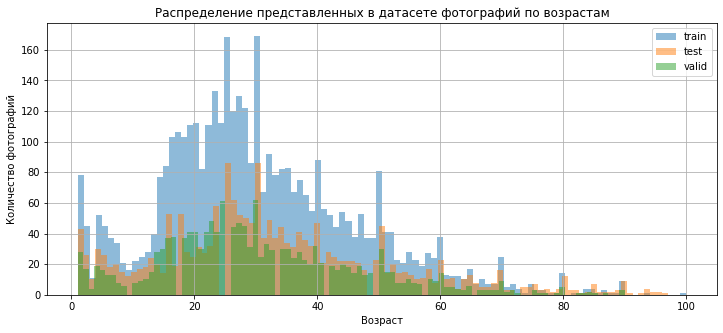

In [11]:
labels_train['real_age'].hist(bins=100, figsize=(12, 5), label='train', alpha=0.5)
labels_test['real_age'].hist(bins=100, figsize=(12, 5), label='test', alpha=0.5)
labels_valid['real_age'].hist(bins=100, figsize=(12, 5), label='valid', alpha=0.5)
plt.title('Распределение представленных в датасете фотографий по возрастам')
plt.xlabel('Возраст')
plt.ylabel('Количество фотографий')
plt.legend()
plt.show()

- Большинсто фотографий обучающего датасета принадлежит людям 13-50 лет. Соответственно, есть предположение, что именно их модель научится различать точнее. 
- Так же видим, что фотографий людей старше 60 достаточно мало, что может затруднить точную интерпретацию возраста для данных фотографий.
- Можем так же отметить пиковые значения некоторых возрастов: 1, 25, 30, 40, 50, 60, 70, 80 и 90 лет - возможно, возраст некоторых людей на фотографиях был прикинут "на глаз" при разметке датасета.

Используем загрузчик `ImageDataGenerator`. Из фотографий в папках класс ImageDataGenerator формирует батчи с изображениями и метками классов. Сделаем предобработку данных: поделим значения яркости на 255.

Чтобы загрузчик извлёк данные из папки, вызовем функцию `flow_from_directory()` 

In [12]:
def preprocess_image(image):
    image = tf.image.resize_with_crop_or_pad(image, SIZE, SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    return image

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_image,
                                   horizontal_flip=True,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   brightness_range=[0.5, 1.2],
                                   )

train_gen_flow = train_datagen.flow_from_dataframe(
    dataframe=labels_train,
    directory='/content/appa-real-release/train',
    x_col='file_name_face',
    y_col='real_age',
    target_size=(SIZE, SIZE),
    batch_size=32,
    class_mode='raw',
    seed=SEED,
    )

valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_image)

valid_gen_flow = valid_datagen.flow_from_dataframe(
    dataframe=labels_valid,
    directory='/content/appa-real-release/valid',
    x_col='file_name_face',
    y_col='real_age',
    target_size=(SIZE, SIZE),
    batch_size=32,
    class_mode='raw',
    seed=SEED,
    )

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_image)

test_gen_flow = test_datagen.flow_from_dataframe(
    dataframe=labels_test,
    directory='/content/appa-real-release/test',
    x_col='file_name_face',
    y_col='real_age',
    target_size=(SIZE, SIZE),
    batch_size=32,
    class_mode='raw',
    seed=SEED,
    )


Found 4113 validated image filenames.
Found 1500 validated image filenames.
Found 1978 validated image filenames.


Загрузчик обнаружил 4113 фотографий для обучающего датасета, 1500 для валидационного и 1978 для тестового. Значение совпадает с количеством фотографий в датасетах `labels_train/valid/test` с метками. 

Сохраним в отдельные переменные сами фотографии и метки возраста для каждой фотографии.

In [13]:
features, target = next(train_gen_flow)

Рассмотрим, как выглядят массивы с данными.

In [14]:
features.shape, target.shape

((32, 224, 224, 3), (32,))

В батче 32 фотографии с разрешением 224х224 и тремя каналами (то есть цветных). Выведем эти фотографии из батча.

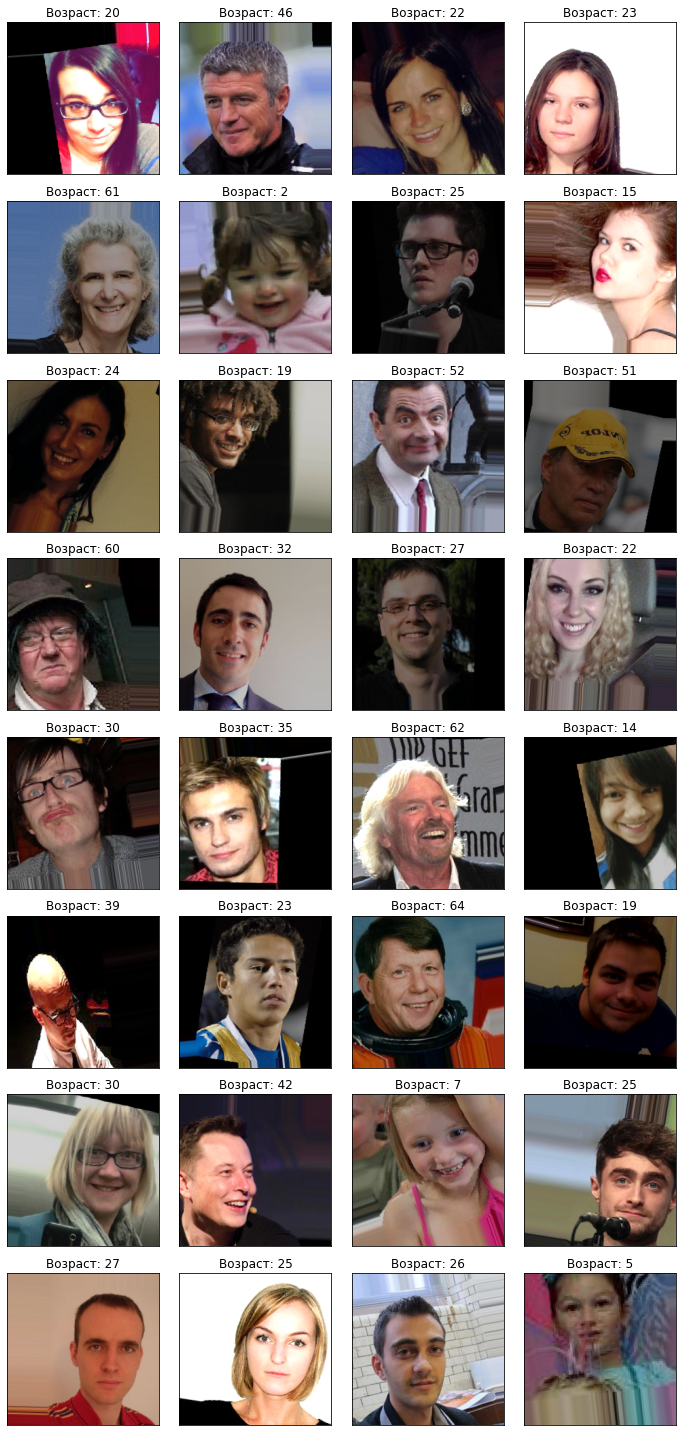

In [15]:
fig = plt.figure(figsize=(10, 20))
for i in range(32):
    fig.add_subplot(8, 4, i + 1)
    plt.imshow(features[i])
    # для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.title(f'Возраст: {target[i]}')

- Датасет представлен различными фотографиями людей: афас, профиль и полубоком, повернутые и нет, цветные и черно-белые.
- Я плохо идентифицирую возраст людей, поэтому поверю в реалистичность указанных возрастов.

## Обучение модели

Ниже представлены функции для создания и обучения модели. 

- `create_model` создает модель на основе `ResNet50` без верхних слоев с использованием весов `'imagenet'`. На данный костяк мы добавили пулинг с окном во весь тензор `GlobalAveragePooling2D` и полносвязный слой для регрессии с одним нейроном. Для обучения нейронной сети мы указали функцию потерь `mean_square_error` - `mse` (так как было сказано, что она обучается быстрее), а для оценки метрики качетсва выбрали `mean absolute error`. В качестве оптимизатора взяли `Adam` c `learning_rate=0.001`.


- `train_model` принимает на вход модель, тренировочный и валидационный датасеты и параметры в виде размера батча и количества эпох. Так же в данной фукции был реализован класс `MyThresholdCallback` на основе `tensorflow.keras.callbacks.Callback`, который отслеживает значения метрики качества на валидационной выборке и позволяет остановить обучение при достижении желаемого значения метрики качества. В данной функции было выбрано значение `mae` на валидационной выборке ниже 6.

In [16]:
# Создание модели
def create_model(input_shape):
    optimizer = Adam(learning_rate=0.0001)
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())

    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    
    model.add(Dense(units=1, activation='relu'))
    model.compile(loss='mse', optimizer=optimizer,
                  metrics=['mae'])
    return model


# Обучение модели
def train_model(model, train_datagen_flow, test_datagen_flow, batch_size=32,
                epochs=30, steps_per_epoch=None, validation_steps=None):

    # установка tensorflow-gpu в качестве backend'а
    tf.keras.backend.set_image_data_format('channels_last')

    class MyThresholdCallback(Callback):
        def __init__(self, threshold):
            super(MyThresholdCallback, self).__init__()
            self.threshold = threshold

        def on_epoch_end(self, epoch, logs=None):
            mae = logs['val_mae']
            if mae <= self.threshold:
                self.model.stop_training = True

    callback = MyThresholdCallback(threshold=6)

    if steps_per_epoch is None:
        steps_per_epoch = len(train_datagen_flow)
    if validation_steps is None:
        validation_steps = len(test_datagen_flow)

    with tf.device('/GPU:0'):
        model.fit(train_datagen_flow,
                  validation_data=test_datagen_flow,
                  steps_per_epoch=steps_per_epoch,
                  validation_steps=validation_steps,
                  epochs=epochs,
                  verbose=2,
                  # callbacks=[callback],
                  callbacks=[callback, model_checkpoint],
                  shuffle=True
                  )
    
    return model

# Сохранение модели
def save_model(model, model_path):
    model.save(model_path)

# Очистка GPU
def clear_gpu_session():
    tf.keras.backend.clear_session()

In [17]:
# Созданние модели
model = create_model((224, 224, 3))

In [18]:
# Настройка ModelCheckpoint callback для сохранения модели во время обучения

model_checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/MyModels/age_prediction_model.h5', 
    monitor='val_mae', 
    mode='min', 
    verbose=1,
    save_best_only=True,
    save_weights_only=False
    )

In [19]:
# Обучение модели закомментированы, чтобы просто подрузить уже обученную модель. 
# Логи обучения представлены ниже.

# model_fitted = train_model(model, train_gen_flow, valid_gen_flow, epochs=40)

Epoch 1/40

Epoch 1: val_mae improved from inf to 22.24991, saving model to /content/drive/MyDrive/MyModels/age_prediction_model.h5
129/129 - 176s - loss: 279.4123 - mae: 12.3099 - val_loss: 724.2966 - val_mae: 22.2499 - 176s/epoch - 1s/step
Epoch 2/40

Epoch 2: val_mae improved from 22.24991 to 19.97178, saving model to /content/drive/MyDrive/MyModels/age_prediction_model.h5
129/129 - 136s - loss: 94.0705 - mae: 7.4048 - val_loss: 615.1952 - val_mae: 19.9718 - 136s/epoch - 1s/step
Epoch 3/40

Epoch 3: val_mae improved from 19.97178 to 17.19056, saving model to /content/drive/MyDrive/MyModels/age_prediction_model.h5
129/129 - 137s - loss: 75.5435 - mae: 6.7006 - val_loss: 494.5899 - val_mae: 17.1906 - 137s/epoch - 1s/step
Epoch 4/40

Epoch 4: val_mae improved from 17.19056 to 16.38400, saving model to /content/drive/MyDrive/MyModels/age_prediction_model.h5
129/129 - 136s - loss: 66.0784 - mae: 6.2729 - val_loss: 448.4422 - val_mae: 16.3840 - 136s/epoch - 1s/step
Epoch 5/40

Epoch 5: val_mae improved from 16.38400 to 10.30396, saving model to /content/drive/MyDrive/MyModels/age_prediction_model.h5
129/129 - 135s - loss: 57.6978 - mae: 5.8284 - val_loss: 181.2433 - val_mae: 10.3040 - 135s/epoch - 1s/step
Epoch 6/40

Epoch 6: val_mae improved from 10.30396 to 8.84404, saving model to /content/drive/MyDrive/MyModels/age_prediction_model.h5
129/129 - 135s - loss: 49.0936 - mae: 5.3955 - val_loss: 140.8065 - val_mae: 8.8440 - 135s/epoch - 1s/step
Epoch 7/40

Epoch 7: val_mae improved from 8.84404 to 7.46964, saving model to /content/drive/MyDrive/MyModels/age_prediction_model.h5
129/129 - 136s - loss: 44.3718 - mae: 5.1154 - val_loss: 102.4134 - val_mae: 7.4696 - 136s/epoch - 1s/step
Epoch 8/40

Epoch 8: val_mae improved from 7.46964 to 6.61110, saving model to /content/drive/MyDrive/MyModels/age_prediction_model.h5
129/129 - 134s - loss: 39.3791 - mae: 4.8219 - val_loss: 84.2993 - val_mae: 6.6111 - 134s/epoch - 1s/step
Epoch 9/40

Epoch 9: val_mae improved from 6.61110 to 6.53537, saving model to /content/drive/MyDrive/MyModels/age_prediction_model.h5
129/129 - 135s - loss: 37.3417 - mae: 4.6819 - val_loss: 80.4884 - val_mae: 6.5354 - 135s/epoch - 1s/step
Epoch 10/40

Epoch 10: val_mae did not improve from 6.53537
129/129 - 132s - loss: 32.7920 - mae: 4.4641 - val_loss: 83.7690 - val_mae: 6.7611 - 132s/epoch - 1s/step
Epoch 11/40

Epoch 11: val_mae did not improve from 6.53537
129/129 - 132s - loss: 31.6731 - mae: 4.2711 - val_loss: 92.7344 - val_mae: 6.8346 - 132s/epoch - 1s/step
Epoch 12/40

Epoch 12: val_mae improved from 6.53537 to 6.36070, saving model to /content/drive/MyDrive/MyModels/age_prediction_model.h5
129/129 - 134s - loss: 26.6147 - mae: 3.9859 - val_loss: 79.0529 - val_mae: 6.3607 - 134s/epoch - 1s/step
Epoch 13/40

Epoch 13: val_mae did not improve from 6.36070
129/129 - 131s - loss: 25.0159 - mae: 3.8693 - val_loss: 95.6869 - val_mae: 7.2945 - 131s/epoch - 1s/step
Epoch 14/40

Epoch 14: val_mae did not improve from 6.36070
129/129 - 131s - loss: 23.4890 - mae: 3.7154 - val_loss: 95.1514 - val_mae: 7.2099 - 131s/epoch - 1s/step
Epoch 15/40

Epoch 15: val_mae did not improve from 6.36070
129/129 - 136s - loss: 23.1243 - mae: 3.6887 - val_loss: 80.3913 - val_mae: 6.4831 - 136s/epoch - 1s/step
Epoch 16/40

Epoch 16: val_mae did not improve from 6.36070
129/129 - 131s - loss: 21.9552 - mae: 3.5814 - val_loss: 82.5365 - val_mae: 6.4702 - 131s/epoch - 1s/step
Epoch 17/40

Epoch 17: val_mae did not improve from 6.36070
129/129 - 130s - loss: 20.3413 - mae: 3.4615 - val_loss: 78.4596 - val_mae: 6.3659 - 130s/epoch - 1s/step
Epoch 18/40

Epoch 18: val_mae improved from 6.36070 to 6.27427, saving model to /content/drive/MyDrive/MyModels/age_prediction_model.h5
129/129 - 134s - loss: 20.1634 - mae: 3.3958 - val_loss: 77.9214 - val_mae: 6.2743 - 134s/epoch - 1s/step
Epoch 19/40

Epoch 19: val_mae did not improve from 6.27427
129/129 - 131s - loss: 18.7961 - mae: 3.3101 - val_loss: 99.2173 - val_mae: 7.4777 - 131s/epoch - 1s/step
Epoch 20/40

Epoch 20: val_mae did not improve from 6.27427
129/129 - 130s - loss: 19.6869 - mae: 3.3794 - val_loss: 81.3272 - val_mae: 6.3869 - 130s/epoch - 1s/step
Epoch 21/40

Epoch 21: val_mae did not improve from 6.27427
129/129 - 135s - loss: 16.4342 - mae: 3.1343 - val_loss: 95.4052 - val_mae: 6.8106 - 135s/epoch - 1s/step
Epoch 22/40

Epoch 22: val_mae did not improve from 6.27427
129/129 - 130s - loss: 16.9217 - mae: 3.1440 - val_loss: 79.9472 - val_mae: 6.4625 - 130s/epoch - 1s/step
Epoch 23/40

Epoch 23: val_mae did not improve from 6.27427
129/129 - 131s - loss: 16.7268 - mae: 3.0912 - val_loss: 78.7905 - val_mae: 6.4377 - 131s/epoch - 1s/step
Epoch 24/40

Epoch 24: val_mae improved from 6.27427 to 6.16015, saving model to /content/drive/MyDrive/MyModels/age_prediction_model.h5
129/129 - 135s - loss: 14.3570 - mae: 2.8992 - val_loss: 75.6216 - val_mae: 6.1601 - 135s/epoch - 1s/step
Epoch 25/40

Epoch 25: val_mae improved from 6.16015 to 6.05973, saving model to /content/drive/MyDrive/MyModels/age_prediction_model.h5
129/129 - 135s - loss: 13.2881 - mae: 2.7565 - val_loss: 74.4547 - val_mae: 6.0597 - 135s/epoch - 1s/step
Epoch 26/40

Epoch 26: val_mae improved from 6.05973 to 6.04789, saving model to /content/drive/MyDrive/MyModels/age_prediction_model.h5
129/129 - 135s - loss: 12.4518 - mae: 2.7148 - val_loss: 71.6967 - val_mae: 6.0479 - 135s/epoch - 1s/step
Epoch 27/40

Epoch 27: val_mae did not improve from 6.04789
129/129 - 131s - loss: 13.3018 - mae: 2.7861 - val_loss: 78.8592 - val_mae: 6.3929 - 131s/epoch - 1s/step
Epoch 28/40

Epoch 28: val_mae did not improve from 6.04789
129/129 - 130s - loss: 12.9718 - mae: 2.7138 - val_loss: 89.5124 - val_mae: 7.0310 - 130s/epoch - 1s/step
Epoch 29/40

Epoch 29: val_mae did not improve from 6.04789
129/129 - 135s - loss: 12.0476 - mae: 2.6371 - val_loss: 80.5784 - val_mae: 6.2453 - 135s/epoch - 1s/step
Epoch 30/40

Epoch 30: val_mae did not improve from 6.04789
129/129 - 131s - loss: 13.2259 - mae: 2.7038 - val_loss: 78.7177 - val_mae: 6.4119 - 131s/epoch - 1s/step
Epoch 31/40

Epoch 31: val_mae did not improve from 6.04789
129/129 - 130s - loss: 12.6280 - mae: 2.7358 - val_loss: 78.0716 - val_mae: 6.2087 - 130s/epoch - 1s/step
Epoch 32/40

Epoch 32: val_mae did not improve from 6.04789
129/129 - 131s - loss: 11.8188 - mae: 2.5587 - val_loss: 75.9692 - val_mae: 6.1736 - 131s/epoch - 1s/step
Epoch 33/40

Epoch 33: val_mae did not improve from 6.04789
129/129 - 131s - loss: 12.6817 - mae: 2.6994 - val_loss: 83.7952 - val_mae: 6.4087 - 131s/epoch - 1s/step
Epoch 34/40

Epoch 34: val_mae did not improve from 6.04789
129/129 - 136s - loss: 16.1084 - mae: 3.0308 - val_loss: 91.1156 - val_mae: 6.6539 - 136s/epoch - 1s/step
Epoch 35/40

Epoch 35: val_mae did not improve from 6.04789
129/129 - 131s - loss: 11.5500 - mae: 2.5892 - val_loss: 77.0332 - val_mae: 6.2078 - 131s/epoch - 1s/step
Epoch 36/40

Epoch 36: val_mae improved from 6.04789 to 5.96063, saving model to /content/drive/MyDrive/MyModels/age_prediction_model.h5
129/129 - 134s - loss: 11.4513 - mae: 2.5867 - val_loss: 73.9026 - val_mae: 5.9606 - 134s/epoch - 1s/step

In [20]:
def predict_model(model, test_gen_flow):
    predictions = []
    for i in range(len(test_gen_flow)):
        batch_images, batch_labels = test_gen_flow[i]
        batch_predictions = model.predict(batch_images, verbose=0)
        predictions.append(batch_predictions)
        
        if i == 0:
            fig = plt.figure(figsize=(10, 20))
            for i in range(32):
                fig.add_subplot(8, 4, i + 1)
                plt.imshow(batch_images[i])
                # для компактности удаляем оси и прижимаем изображения друг к другу
                plt.xticks([])
                plt.yticks([])
                plt.tight_layout()
                plt.title(f'Возраст: {batch_labels[i]}\n Предсказание:{np.round(batch_predictions[i])}')
            plt.show()

    predictions = np.concatenate(predictions, axis=0)
    mae = np.mean(np.abs(predictions - test_gen_flow.labels))
    return predictions, mae

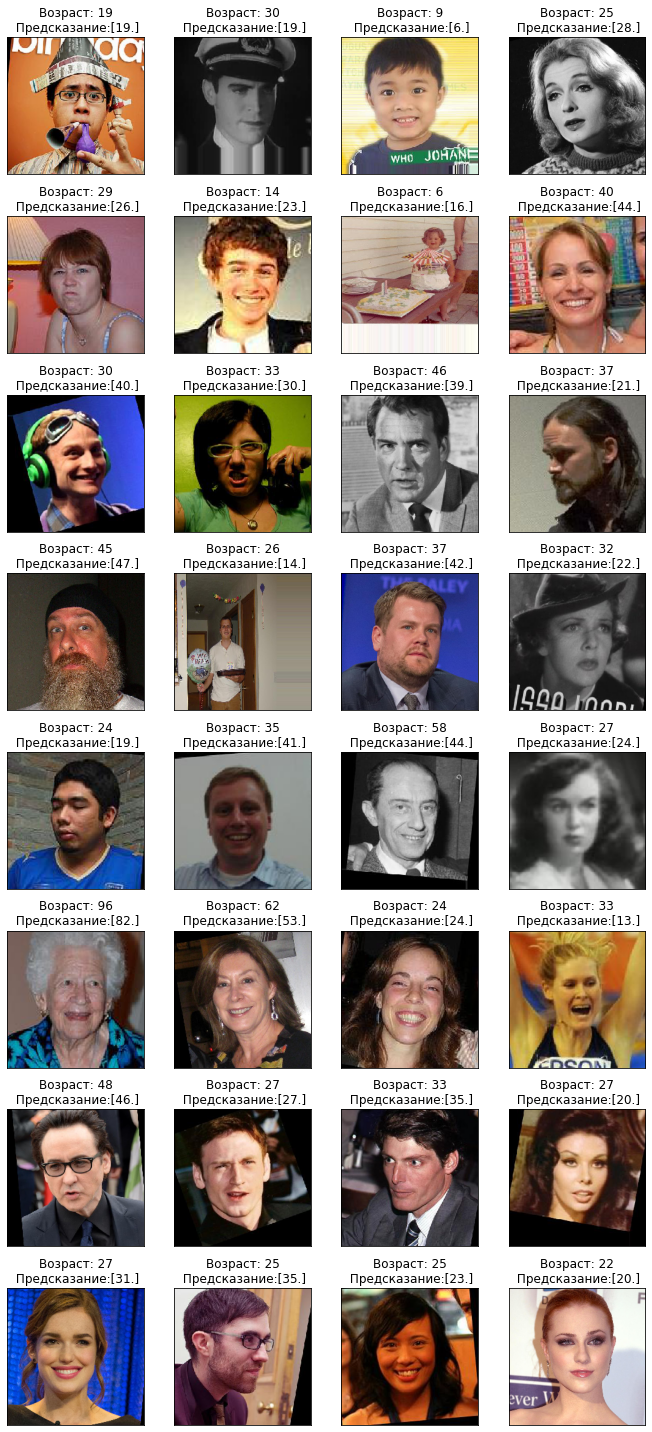

In [ ]:
# Загрузка сохраненной модели
model = tf.keras.models.load_model('/content/gdrive/MyDrive/MyModels/age_prediction_model.h5')

# Получение предсказаний и MAE на тестовых данных
test_predictions, test_mae = predict_model(model, test_gen_flow)

# Вывод MAE на тестовых данных
print('Test MAE:', test_mae)

Обучение модели на 36 эпохах позволило добиться метрики качества **`mae` менее 6 лет** на валидационной выборке, при этом `mae` на тренировочной выборке оказалось `2.6` лет. **Модель немного переобучилась**. Однако тестовые результаты показали `mae` в районе 20 лет, что достаточно плохо. При визуальном анализе результатов модели можно сделать вывод, что она неплохо справляется с людьми среднего возраста, но плохо идентифицирует детей и пожилых людей (так как их было меньшинство в обучающем датасете), а так же справляется очень плохо, если лица не видно. Так же возможно обучающий датасет был маловат (чуть больше 4 тысяч фотографий).

Напомним, что сетевой супермаркет "Хлеб-Соль" хочет использовать фотофиксацию в прикассовой зоне чтобы:

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы. С данной задачей модель должна справиться - **визуально она неплохо определяет возраст людей 13-50 лет**.  

- Контролировать добросовестность кассиров при продаже алкоголя. С данным пунктом гораздо сложнее, так как продажа алкоголя начинается всегда с определенного возраста, и ошибок быть не должно. Так как некоторые люди выглядят то моложе, то старше своего возраста, опираться на модель с точностью определения возраста в несколько лет является недопустимым, так что **модель рекомендовалось бы использовать в качестве вспомогательного средства** при проверке возраста покупателя.

- Так же модель не справляется с угадыванием возраста, если фотография слишком темная, человек находится слишком далеко и прочими сложностями.